# WhatsApp Chat analyzer
This notebook will read exported whatsapp chat and then visualize the extracted data
You may need to install some packages before run it

#### Note
Please run all cells to get all cells work

In [1]:
# -*- coding: utf-8 -*-
import re
import unicodedata
import operator
import string
import emoji
import pandas as pd
from datetime import datetime
#Common word dict
#If you prefer to use any language other than Indonesian, please include the file
from id_cw import common_words
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

%matplotlib inline


filepath = "/Users/glam/Documents/Mainan Data/_chat.txt"

In [2]:
"""
---------------
EVENT CHAT
---------------
    An event like member added, member left is detected when follow below rules:
        - Started with timestamp format: [10/06/17 15.38.20]
        - Followed with a space
        - Then followed with "‎" (\u200e) character
        - Followed with a member subject without space
        - Followed with a space
        - Followed with event name
        
    example:
        - a member aded another member:
            [30/06/17 15.00.30] ‎Soekarno added ‪+62 123‑4567‑8910‬
        - a member left the group:
            [30/06/17 14.28.53] ‎‪+62 123‑4567‑8910‬‬ left
"""
def is_event(line):
    pattern = re.compile(r"""
        (       #Group 1 open: Timestamp to match [30/06/17 14.28.53]
          \[    #Square brackets open start of timestamp
          [0-3] #First digit of a date
          \d    #Second digit of date
          /     #Slash delimiter
          [0-1] #First digit of month
          \d    #Second digit of month
          /     #Slash delimiter
          \d    #First digit of year
          \d    #Second digit of year
          \s    #Space sparation between date and time
          [0-2] #First digit of hour
          \d    #Second digit of hour
          \.    #Dots character (sparation from hour and minute)
          [0-5] #First Digit of minute max: 50
          \d    #Second digit of minute
          \.    #Dots character (sparation from minute and second)
          [0-5] #First character of second
          [0-9] #Second character of second
          \]    #Square brackets close end of timestamp
        )       #Grup 1 clise: Timestamp
        \s      #Space sparation between timestamp and event description
        ([\u200e].*) # a "‎" (\u200e) character and event description
        """, re.VERBOSE)
    
    match = re.match(pattern, line)
    if match:
        
        return match
    else:
        return None

"""
---------------
CHAT
---------------
    A chat is detected when follow below rules:
        - Started with timestamp format: [10/06/17 15.38.20]
        - Followed with a space
        - Then followed with a member subject phone number or saved contact name (ANY character NOT "‎" (\u200e) character)
        - Followed with ":" colon
        - Followed with a single space
        
    example:
        - a chat from saved contact:
            [30/06/17 15.03.15] ‪Habiebie‬: Kakeh korbinah..
        - a chat from unsaved contact:
            [30/06/17 15.03.15] ‪Habiebie‬: Kakeh korbinah..
"""
def is_chat(line):
    pattern = re.compile(r"""
        (       #Group 1 open: Timestamp to match [30/06/17 14.28.53]
          \[    #Square brackets open start of timestamp
          [0-3] #First digit of a date
          \d    #Second digit of date
          /     #Slash delimiter
          [0-1] #First digit of month
          \d    #Second digit of month
          /     #Slash delimiter
          \d    #First digit of year
          \d    #Second digit of year
          \s    #Space sparation between date and time
          [0-2] #First digit of hour
          \d    #Second digit of hour
          \.    #Dots character (sparation from hour and minute)
          [0-5] #First Digit of minute max: 50
          \d    #Second digit of minute
          \.    #Dots character (sparation from minute and second)
          [0-5] #First character of second
          [0-9] #Second character of second
          \]    #Square brackets close end of timestamp
        )       #Grup 1 clise: Timestamp
        \s      #Space sparation between timestamp and chat sender
        ([^:]+?)#Chat sender match any character not ":" until ":" charachter
        (\s*[:])\s #Colon and Space sparation between chat sender and chat content
        (.*) #Chat content
        """, re.VERBOSE)
    match = re.match(pattern, line)
    
    if match:
        return match
    else:
        return None

"""
---------------
ATTACHMENT CHAT
---------------
    An attachment chat is detected when follow below rules:
        - Started with "‎" (\u200e)
        - Followed with timestamp format: [10/06/17 15.38.20]
        - Followed with a space
        - Then followed with a member subject phone number or saved contact name (ANY character NOT "‎" (\u200e) character)
        - Followed with ":" colon
        - Followed with a single space
        - Followed with ANY character and MAY contains "‎" (\u200e) character. But if so, extract if match attachment pattern
        
    example:
        - Image:
            ‎[06/07/17 13.23.30] ‪+62 123-456-78910‬: ‎image omitted
        - Video:
            ‎[06/07/17 09.41.53] ‪+62 123-456-78910‬: ‎video omitted
        - GIF:
            ‎[31/08/17 19.36.52] ‪+62 123-456-78910‬: ‎GIF omitted
        - Audio:
            ‎[01/09/17 08.28.33] +62 123-456-78910‬: ‎audio omitted
        - Sticker:
            ‎[14/11/18 11.00.16] Megawati SP: ‎sticker omitted
        - Document attachment:
            ‎[12/07/17 05.47.04] Jendral Soeharto: GBHN & UUD_1945 • ‎8 pages ‎document omitted"
        - Contact Card attachment
            ‎[29/12/17 19.54.55] ‪+62 123-456-78910‬: ‎Contact card omitted
        
            
"""
def is_attachment(line):
    pattern = "([\u200e])(\[[0-3]\d/[0-1]\d/\d\d\s[0-2]\d\.[0-5]\d\.[0-5][0-9]\])\s([^:]+?)(\s*[:])\s(.*)"
    match = re.match(pattern, line)
    
    if match:
        return match
    else:
        return None

"""
Counter Function
"""

chat_of_members = {}
member_chat = {"member": [], "chat_count": []}
attachments = {
    "image_count" : 0, 
    "video_count" : 0, 
    "audio_count" : 0, 
    "document_count" : 0, 
    "contact_card_count": 0,
    "gif_count": 0,
    "sticker_count" : 0
}
link_count = 0
refered_website = {}
popular_words = {}
chat_words = ""
emojis = {}
heat_map = {"day": [], "hour": [], "chat_count": []}

"""
Rank the 'Most Active user'
"""        
def increment_chat_count(member):
    
    m = re.sub(r'[^\x00-\x7f]',r'', member)
    if m:
        chat_of_members[m] = chat_of_members.get(m, 0) + 1
        member_chat["member"].append(m)
        member_chat["chat_count"].append(1)
    
    return m
    
def increment_attachment_count(line):
    if "‎image omitted" in line:
        attachments["image_count"] += 1
        
    if "‎video omitted" in line:
        attachments["video_count"] += 1

    if "‎audio omitted" in line:
        attachments["audio_count"] += 1
        
    if "‎document omitted" in line:
        attachments["document_count"] += 1
    if "‎Contact card omitted" in line:
        attachments["contact_card_count"] += 1
    if "‎GIF omitted" in line:
        attachments["gif_count"] += 1
    if "‎sticker omitted" in line:
        attachments["sticker_count"] += 1

"""
Check if chat contais a url
"""
def contains_url(line):
    pattern = "https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+"
    
    match = re.findall(pattern, line)
    if len(match) > 0:
        for url in match:
            domain = get_domain(url)
            refered_website[domain] = refered_website.get(domain, 0) + 1
            
            
    return len(match)

def get_domain(str):
    domain = str.replace("http://", '')
    domain = domain.replace("https://", '')
    domain = domain.split("/")
    
    return domain[0]


"""
EMOJI
"""
def extract_emojis(string):
    emj = []
    for c in string:
        if c in emoji.UNICODE_EMOJI:
            emojis[c] = emojis.get(c, 0) + 1
            emj.append(c)
            
    return emj

"""
EXTRACT TIMESTAMP
"""
def extract_timestamp(time_string):
    datetime_object = datetime.strptime(time_string, '[%d/%m/%y %H.%M.%S]')
    heat_map["day"].append(datetime_object.strftime("%A"))
    heat_map["hour"].append(datetime_object.strftime("%H"))
    heat_map["chat_count"].append(1)
    
    return datetime_object

"""
Count top words
"""
def get_words(line):
    
    #remove non alpha content
    regex = re.sub(r"[^a-z\s]+", "", line.lower())
    regex = re.sub(r'[^\x00-\x7f]',r'', regex)
    words = regex.split(" ")
    
    for x in words:
        if x:
            rank_word(x)
            
    return words

def rank_word(word):
    
    if not word in common_words:
        popular_words[word] = popular_words.get(word, 0) + 1
        extract_emojis(word)
        global chat_words
        chat_words += " {0}".format(word)
        
    return word

## File Reading
Lets open, read, and strip some characters of each line

In [3]:
"""
Read file
"""
with open(filepath, "r") as f:
    content = f.readlines()

content = [x.strip() for x in content]

In [4]:

"""
Extraction process
"""
current_chat_sender = ""
for i in range(0, len(content) - 1):
    prefix = ""
    event =  is_event(content[i])
    chat = is_chat(content[i])
    attachment = is_attachment(content[i])
    
    if event:
        prefix = "---"
        extract_timestamp(event.group(1))
    elif chat:
        prefix = "+++"
        increment_chat_count(chat.group(2))
        link_count += contains_url(chat.group(4))
        get_words(chat.group(4))
        extract_emojis(chat.group(4))
        extract_timestamp(chat.group(1))
    elif attachment:
        prefix = "@@@"
        increment_attachment_count(attachment.group(5))
        extract_timestamp(attachment.group(2))
    else:
        prefix = "|||"
        link_count += contains_url(content[i])
        get_words(content[i])
        extract_emojis(content[i])
    
    #print(prefix + content[i])
    
sorted_website = sorted(refered_website.items(), key = operator.itemgetter(1), reverse = True)
sorted_member = sorted(chat_of_members.items(), key=operator.itemgetter(1), reverse=True)
sorted_words = sorted(popular_words.items(), key=operator.itemgetter(1), reverse=True)
sorted_emojis = sorted(emojis.items(), key=operator.itemgetter(1), reverse=True)

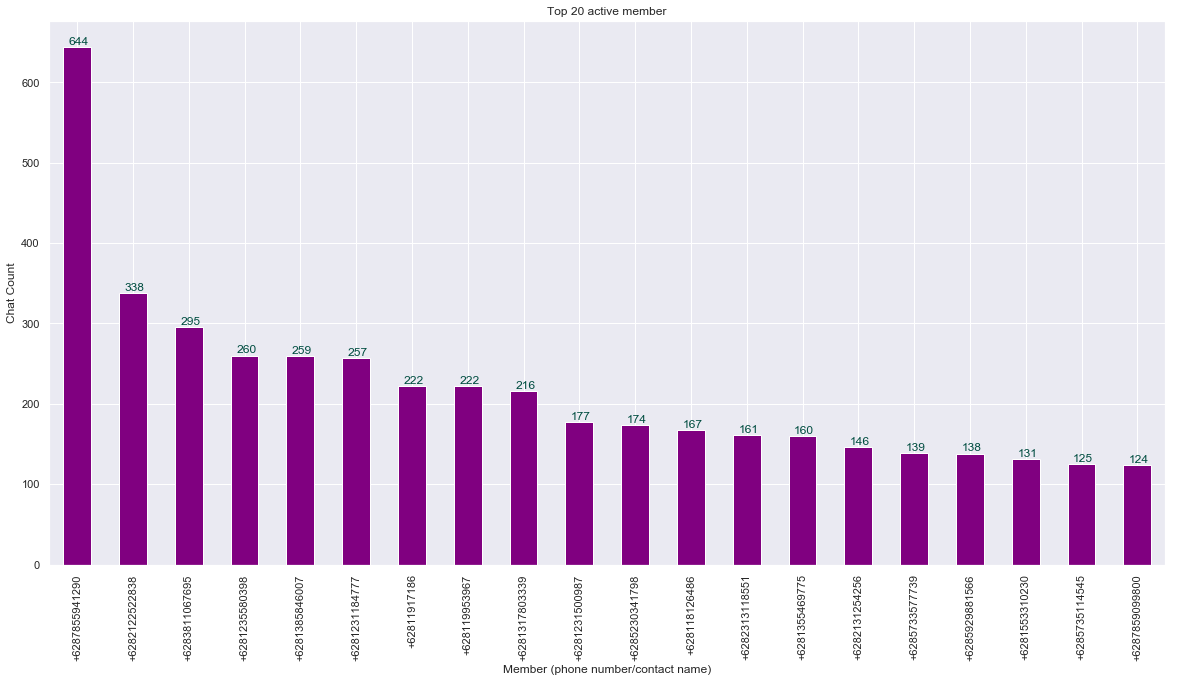

In [5]:
"""
Most active member Bar Chart
"""
sns.set()
member_m = pd.DataFrame(member_chat)
top_member = member_m.groupby(["member"]).sum().sort_values(by = ['chat_count'], ascending=False).head(20)
member_plot = top_member.plot(kind='bar', legend=None, title="Top 20 active member", figsize=(20,10), color="purple")
member_plot.set_xlabel("Member (phone number/contact name)")
member_plot.set_ylabel("Chat Count")
for i, v in enumerate(top_member["chat_count"]):
    member_plot.text(i - .15, v + 3, v, color="#004d40")

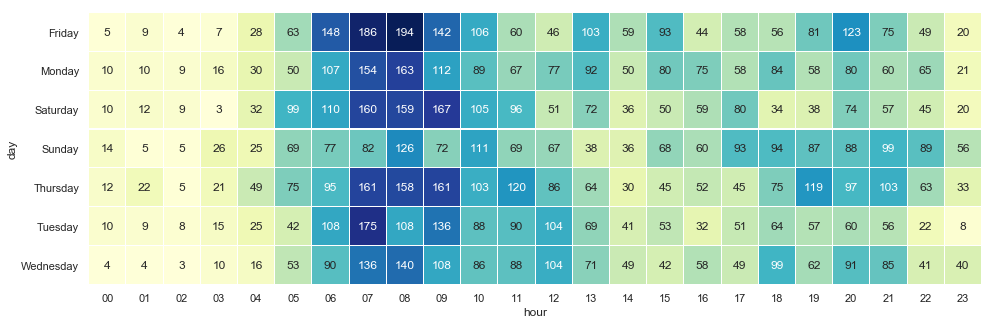

In [6]:
"""
Heatmap
"""
heatmap_df = pd.DataFrame(heat_map)
grouped_heatmap = heatmap_df.groupby(["day", "hour"]).sum().sort_values(by=["chat_count"], ascending=False)
pivoted_heatmap = pd.pivot_table(grouped_heatmap, values='chat_count', index=['day'], columns=['hour'])
plt.figure(figsize = (16,5))
sns.heatmap(pivoted_heatmap, 
            annot=True, 
            fmt="d", 
            linewidths=.2,
            cmap="YlGnBu",
            cbar=False
           )

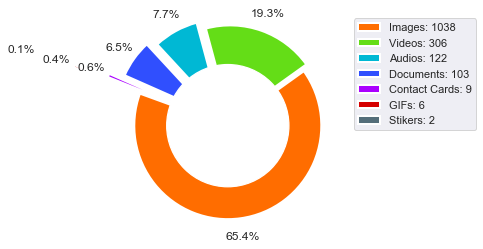

In [7]:
at_labels = [
    "Images: {0}".format(attachments.get("image_count")),
    "Videos: {0}".format(attachments.get("video_count")),
    "Audios: {0}".format(attachments.get("audio_count")),
    "Documents: {0}".format(attachments.get("document_count")),
    "Contact Cards: {0}".format(attachments.get("contact_card_count")),
    "GIFs: {0}".format(attachments.get("gif_count")),
    "Stikers: {0}".format(attachments.get("sticker_count")),
]

at_explode = (0, 0.1, 0.2, 0.3, 0.5, 1, 1.5)
at_sizes = list(attachments.values())
at_colors = ["#FF6D00", "#64DD17", "#00B8D4", "#304FFE", "#AA00FF", "#d50000", "#546E7A"]
at_pie = plt.pie(at_sizes,  
         autopct='%1.1f%%',
         explode=at_explode,
         pctdistance=1.2,
         colors=at_colors,
         startangle=160,
         radius=1.3,
         wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' },
)

at_centre_circle = plt.Circle((0,0),0.85,color='white', fc='white',linewidth=1.25)
at_fig = plt.gcf()
at_fig.gca().add_artist(at_centre_circle)

plt.legend(
    loc='upper left',
    labels=at_labels,
    prop={'size': 11},
    bbox_to_anchor=(1, 1)
)
at_axis = plt.axis('equal')

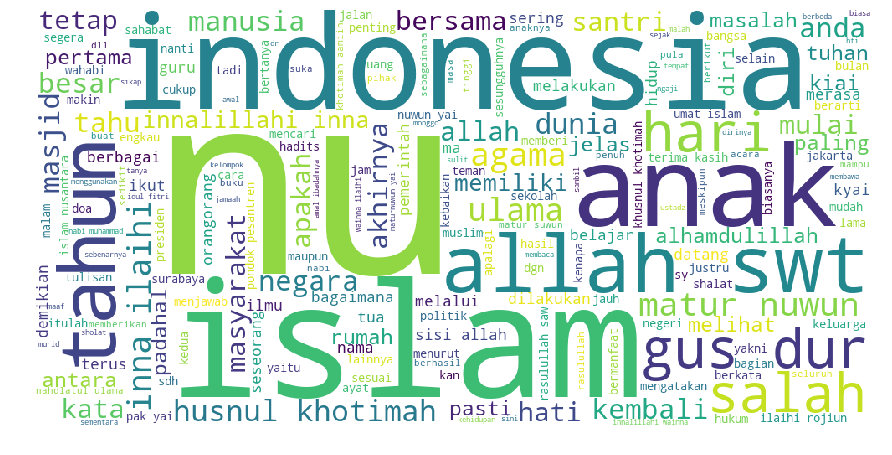

In [8]:
"""
Wordcloud
"""
wordcloud = WordCloud(
    width = 1000, 
    height = 500,
    background_color = "white"
).generate(chat_words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

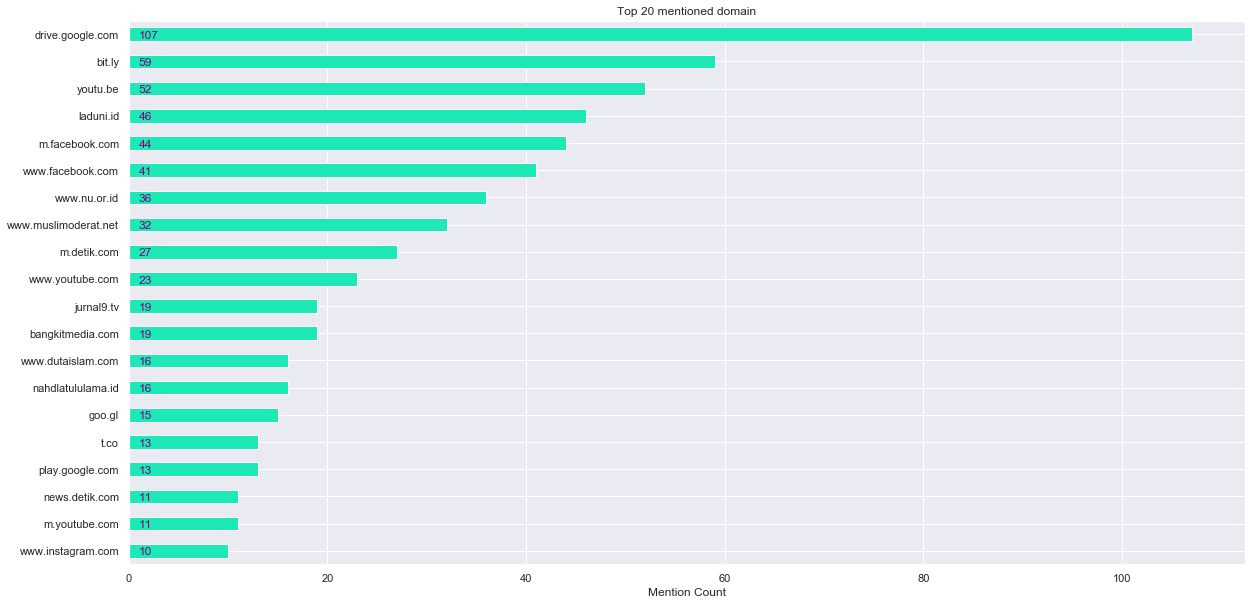

In [9]:
"""
Top Website
"""
# -*- coding: utf-8 -*- 
mpl.rc('font', **{'sans-serif' : 'arial', 'family' : 'sans-serif'})
w_df = pd.DataFrame(sorted_website, columns=["domain", "count"])
top_web = w_df.head(20).sort_values("count")
web_plot = top_web.plot(kind='barh', legend=None, title="Top 20 mentioned domain", figsize=(20,10), color="#1de9b6")
y_tict = [x for x in top_web["domain"]]
web_plot.set_xlabel("Mention Count")
web_plot.set_yticklabels(y_tict)
top_web
for i, v in enumerate(top_web["count"]):
    web_plot.text(1, i - .15, v, color="purple")

### Charting Emoji
I'm struggling in charting emoji. Adding emoji to matplotlib chart is not easy for me 😅

### Raw Print

In [10]:
"""
Print Raw Result
"""
print("-----------")
print("Chat Count: {0}".format(sum(chat_of_members.values())))
print("-----------")
print("Total Attachment: {0}".format(sum(attachments.values())))
print("Images: {0}".format(attachments["image_count"]))
print("Videos: {0}".format(attachments["video_count"]))
print("Audios: {0}".format(attachments["audio_count"]))
print("Documents: {0}".format(attachments["document_count"]))
print("Contact Cards: {0}".format(attachments["contact_card_count"]))
print("GIF: {0}".format(attachments["gif_count"]))
print("Sticker: {0}".format(attachments["sticker_count"]))
print("\n")
print("-----------")
print("Links count: {0}".format(link_count))
print("-----------")
print("Top 10 Mentioned Website:")
index = 0
for i in sorted_website:
    if index < 10:
        print("{0}".format(i))
    index += 1
          
print("\n")
print("-----------")
print("Top 20 Mamber Rank: ")
print("-----------")
index = 0
for i in sorted_member:
    if index < 20:
        print("{0}".format(i))
    index += 1
    
print("\n")
print("-----------")
print("Top 20 Words: ")
print("-----------")
index = 0
for i in sorted_words:
    if index < 20:
        print("{0}".format(i))
    index += 1
print("\n")
print("-----------")
print("Top 20 Emojis: ")
print("-----------")
index = 0
for i in sorted_emojis:
    if index < 20:
        print("{0}".format(i))
    index += 1


-----------
Chat Count: 9499
-----------
Total Attachment: 1586
Images: 1038
Videos: 306
Audios: 122
Documents: 103
Contact Cards: 9
GIF: 6
Sticker: 2


-----------
Links count: 1188
-----------
Top 10 Mentioned Website:
('drive.google.com', 107)
('bit.ly', 59)
('youtu.be', 52)
('laduni.id', 46)
('m.facebook.com', 44)
('www.facebook.com', 41)
('www.nu.or.id', 36)
('www.muslimoderat.net', 32)
('m.detik.com', 27)
('www.youtube.com', 23)


-----------
Top 20 Mamber Rank: 
-----------
('+6287855941290', 644)
('+6282122522838', 338)
('+6283811067695', 295)
('+6281235580398', 260)
('+6281385846007', 259)
('+6281231184777', 257)
('+62811917186', 222)
('+628119953967', 222)
('+6281317803339', 216)
('+6281231500987', 177)
('+6285230341798', 174)
('+628118126486', 167)
('+6282313118551', 161)
('+6281355469775', 160)
('+6282131254256', 146)
('+6285733577739', 139)
('+6285929881566', 138)
('+6281553310230', 131)
('+6285735114545', 125)
('+6287859099800', 124)


-----------
Top 20 Words: 
---------